In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from sklearn.model_selection import KFold

In [2]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.80; # 80% to train, includes validation
train_size=int(trp*num)
test_size = num - train_size 

# spatial slicing dimensions
os = 1 # output slice size
halo = 15 # edge cells
ts = os + halo * 2 # total input slice size including halos 31 and overlap30 pixels
ks = int(6) # kernel size 6
l2r = 4066; # number of slices in one profile; 15 halo size on each side ;4066+15+15=4096



In [3]:
print(train_size,test_size)

3200 800


In [4]:
#spatial slicing the 4000 profiles 

image=np.zeros((l2r*num,ts,3)) 
label=np.zeros((l2r*num,os)) 

#cut each profile into 4066 slices. 
#label: tau channel of the center of each slice(reduced domain)
for i in range(num):
    for n in range(l2r):
        img= data[i,n*os:n*os+ts, 0:nchan] #input: 12 pixels for one slice, 3 channels 
        lb = data[i,n*os+halo:n*os+halo+os, nchan] #8 pixels for label,the tau channel is the label
        image[i*l2r+n]=img
        label[i*l2r+n]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) #4066*4000=16264000


whole dataset features size:  (16264000, 31, 3) whole dataset label size:  (16264000, 1)


In [5]:
predictions = np.empty((test_size,1)) 
predictions.shape

(800, 1)

In [7]:
# CNN over domain -------------------------------------------


def evaluate_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 1024
    eps = 2000
    
    model_m = models.Sequential()
    model_m.add(layers.Conv1D(nchan*100, kernel_size=ks, activation='relu', input_shape=(ts, nchan))) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.Conv1D(nchan*80, kernel_size=4, activation='relu')) #kernel size 4, 80 filters for each 3 channel
    model_m.add(layers.Dropout(0.2))
    model_m.add(layers.Conv1D(8, kernel_size=1)) 
    model_m.add(layers.Dropout(0.2))
    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 1

    model_m.summary()


    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 50,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse = results[2]

    return model_m,rmse,mse,history,predictions

In [10]:
#5 folds cross validation 

n_folds=5
kf = KFold(n_splits=n_folds)
kf.get_n_splits(image)
print(kf)
ratio=int(image.shape[0]/n_folds)
print('Ratio:',ratio)
print('Total: ',image.shape[0])
print('train folds data number:',ratio*4)
print('test fold data number:',ratio)

KFold(n_splits=5, random_state=None, shuffle=False)
Ratio: 3252800
Total:  16264000
train folds data number: 13011200
test fold data number: 3252800


In [ ]:
cv_scores= list()
cv_scores2=list()
model_history=list()

count=1
for train_index, test_index in kf.split(image):
 
    print("TRAIN:", train_index, "TEST:", test_index)
    train_image, test_image = image[train_index], image[test_index]
    train_label, test_label = label[train_index], label[test_index]

    model_m,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(count)+' : '+str(mse))
    print('RMSE on test set in fold'+str(count)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

count+=1
    

TRAIN: [ 3252800  3252801  3252802 ... 16263997 16263998 16263999] TEST: [      0       1       2 ... 3252797 3252798 3252799]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 26, 300)           5700      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 240)           288240    
_________________________________________________________________
dropout (Dropout)            (None, 23, 240)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 8)             1928      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 8)             0         
_________________________________________________________________
flatten (Flatten)            (None, 184)               0     

11118/11118 [==============================] - 136s 12ms/step - loss: 7.2568 - mean_squared_error: 7.2568 - root_mean_squared_error: 2.6938 - val_loss: 5.4483 - val_mean_squared_error: 5.4483 - val_root_mean_squared_error: 2.3342
Epoch 28/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 7.1507 - mean_squared_error: 7.1507 - root_mean_squared_error: 2.6741 - val_loss: 5.4691 - val_mean_squared_error: 5.4691 - val_root_mean_squared_error: 2.33867.1509 - mean_squared_error: 7.
Epoch 29/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 7.1213 - mean_squared_error: 7.1213 - root_mean_squared_error: 2.6686 - val_loss: 5.4974 - val_mean_squared_error: 5.4974 - val_root_mean_squared_error: 2.3447
Epoch 30/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 7.0112 - mean_squared_error: 7.0112 - root_mean_squared_error: 2.6479 - val_loss: 5.3451 - val_mean_squared_error: 5.3451 - val_root_mean_squared_error: 2.3119
Epoch 3

11118/11118 [==============================] - 135s 12ms/step - loss: 6.0896 - mean_squared_error: 6.0896 - root_mean_squared_error: 2.4677 - val_loss: 4.9909 - val_mean_squared_error: 4.9909 - val_root_mean_squared_error: 2.2340
Epoch 61/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 6.0790 - mean_squared_error: 6.0790 - root_mean_squared_error: 2.4655 - val_loss: 4.7408 - val_mean_squared_error: 4.7408 - val_root_mean_squared_error: 2.1773
Epoch 62/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 6.0277 - mean_squared_error: 6.0277 - root_mean_squared_error: 2.4551 - val_loss: 4.5772 - val_mean_squared_error: 4.5772 - val_root_mean_squared_error: 2.1394_mean_squared_e
Epoch 63/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 6.0473 - mean_squared_error: 6.0473 - root_mean_squared_error: 2.4591 - val_loss: 4.6769 - val_mean_squared_error: 4.6769 - val_root_mean_squared_error: 2.1626
Epoch 64/2000
11118/111

11118/11118 [==============================] - 135s 12ms/step - loss: 5.5935 - mean_squared_error: 5.5935 - root_mean_squared_error: 2.3650 - val_loss: 4.2124 - val_mean_squared_error: 4.2124 - val_root_mean_squared_error: 2.0524
Epoch 94/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.5833 - mean_squared_error: 5.5833 - root_mean_squared_error: 2.3629 - val_loss: 4.1783 - val_mean_squared_error: 4.1783 - val_root_mean_squared_error: 2.0441
Epoch 95/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.5767 - mean_squared_error: 5.5767 - root_mean_squared_error: 2.3615 - val_loss: 4.2132 - val_mean_squared_error: 4.2132 - val_root_mean_squared_error: 2.0526
Epoch 96/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.5310 - mean_squared_error: 5.5310 - root_mean_squared_error: 2.3518 - val_loss: 4.4770 - val_mean_squared_error: 4.4770 - val_root_mean_squared_error: 2.1159
Epoch 97/2000
11118/11118 [===========

11118/11118 [==============================] - 135s 12ms/step - loss: 5.1819 - mean_squared_error: 5.1819 - root_mean_squared_error: 2.2764 - val_loss: 3.7800 - val_mean_squared_error: 3.7800 - val_root_mean_squared_error: 1.9442
Epoch 127/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.1890 - mean_squared_error: 5.1890 - root_mean_squared_error: 2.2779 - val_loss: 3.8582 - val_mean_squared_error: 3.8582 - val_root_mean_squared_error: 1.9642
Epoch 128/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.1831 - mean_squared_error: 5.1831 - root_mean_squared_error: 2.2766 - val_loss: 3.8116 - val_mean_squared_error: 3.8116 - val_root_mean_squared_error: 1.9523
Epoch 129/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.1535 - mean_squared_error: 5.1535 - root_mean_squared_error: 2.2701 - val_loss: 3.9484 - val_mean_squared_error: 3.9484 - val_root_mean_squared_error: 1.9871
Epoch 130/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 5.0341 - mean_squared_error: 5.0341 - root_mean_squared_error: 2.2437 - val_loss: 3.7063 - val_mean_squared_error: 3.7063 - val_root_mean_squared_error: 1.9252
Epoch 160/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.9954 - mean_squared_error: 4.9954 - root_mean_squared_error: 2.2350 - val_loss: 3.8682 - val_mean_squared_error: 3.8682 - val_root_mean_squared_error: 1.9668
Epoch 161/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.9905 - mean_squared_error: 4.9905 - root_mean_squared_error: 2.2339 - val_loss: 3.9859 - val_mean_squared_error: 3.9859 - val_root_mean_squared_error: 1.9965
Epoch 162/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.0054 - mean_squared_error: 5.0054 - root_mean_squared_error: 2.2373 - val_loss: 3.8721 - val_mean_squared_error: 3.8721 - val_root_mean_squared_error: 1.9678
Epoch 163/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.7448 - mean_squared_error: 4.7448 - root_mean_squared_error: 2.1782 - val_loss: 3.5425 - val_mean_squared_error: 3.5425 - val_root_mean_squared_error: 1.8822
Epoch 193/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.7646 - mean_squared_error: 4.7646 - root_mean_squared_error: 2.1828 - val_loss: 3.5880 - val_mean_squared_error: 3.5880 - val_root_mean_squared_error: 1.8942
Epoch 194/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.7390 - mean_squared_error: 4.7390 - root_mean_squared_error: 2.1769 - val_loss: 3.5485 - val_mean_squared_error: 3.5485 - val_root_mean_squared_error: 1.8838
Epoch 195/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.7195 - mean_squared_error: 4.7195 - root_mean_squared_error: 2.1724 - val_loss: 3.7325 - val_mean_squared_error: 3.7325 - val_root_mean_squared_error: 1.9320
Epoch 196/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.6002 - mean_squared_error: 4.6002 - root_mean_squared_error: 2.1448 - val_loss: 3.3158 - val_mean_squared_error: 3.3158 - val_root_mean_squared_error: 1.8209
Epoch 226/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.5890 - mean_squared_error: 4.5890 - root_mean_squared_error: 2.1422 - val_loss: 3.7715 - val_mean_squared_error: 3.7715 - val_root_mean_squared_error: 1.9420
Epoch 227/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.5793 - mean_squared_error: 4.5793 - root_mean_squared_error: 2.1399 - val_loss: 3.5415 - val_mean_squared_error: 3.5415 - val_root_mean_squared_error: 1.8819
Epoch 228/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.5681 - mean_squared_error: 4.5681 - root_mean_squared_error: 2.1373 - val_loss: 3.3762 - val_mean_squared_error: 3.3762 - val_root_mean_squared_error: 1.8374
Epoch 229/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.5024 - mean_squared_error: 4.5024 - root_mean_squared_error: 2.1219 - val_loss: 3.3530 - val_mean_squared_error: 3.3530 - val_root_mean_squared_error: 1.8311
Epoch 259/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.4950 - mean_squared_error: 4.4950 - root_mean_squared_error: 2.1201 - val_loss: 3.6566 - val_mean_squared_error: 3.6566 - val_root_mean_squared_error: 1.9122
Epoch 260/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.4705 - mean_squared_error: 4.4705 - root_mean_squared_error: 2.1144 - val_loss: 3.2926 - val_mean_squared_error: 3.2926 - val_root_mean_squared_error: 1.8146
Epoch 261/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.4603 - mean_squared_error: 4.4603 - root_mean_squared_error: 2.1119 - val_loss: 3.3899 - val_mean_squared_error: 3.3899 - val_root_mean_squared_error: 1.8412
Epoch 262/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.3995 - mean_squared_error: 4.3995 - root_mean_squared_error: 2.0975 - val_loss: 3.3639 - val_mean_squared_error: 3.3639 - val_root_mean_squared_error: 1.8341
Epoch 292/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.3987 - mean_squared_error: 4.3987 - root_mean_squared_error: 2.0973 - val_loss: 3.2694 - val_mean_squared_error: 3.2694 - val_root_mean_squared_error: 1.8082
Epoch 293/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.4168 - mean_squared_error: 4.4168 - root_mean_squared_error: 2.1016 - val_loss: 3.2631 - val_mean_squared_error: 3.2631 - val_root_mean_squared_error: 1.8064
Epoch 294/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.3727 - mean_squared_error: 4.3727 - root_mean_squared_error: 2.0911 - val_loss: 3.5023 - val_mean_squared_error: 3.5023 - val_root_mean_squared_error: 1.8714
Epoch 295/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.3070 - mean_squared_error: 4.3070 - root_mean_squared_error: 2.0753 - val_loss: 3.2827 - val_mean_squared_error: 3.2827 - val_root_mean_squared_error: 1.8118
Epoch 325/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.3141 - mean_squared_error: 4.3141 - root_mean_squared_error: 2.0770 - val_loss: 3.1799 - val_mean_squared_error: 3.1799 - val_root_mean_squared_error: 1.7832
Epoch 326/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.3053 - mean_squared_error: 4.3053 - root_mean_squared_error: 2.0749 - val_loss: 3.2856 - val_mean_squared_error: 3.2856 - val_root_mean_squared_error: 1.8126
Epoch 327/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 4.3091 - mean_squared_error: 4.3091 - root_mean_squared_error: 2.0758 - val_loss: 3.2546 - val_mean_squared_error: 3.2546 - val_root_mean_squared_error: 1.8041
Epoch 328/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.2510 - mean_squared_error: 4.2510 - root_mean_squared_error: 2.0618 - val_loss: 3.0997 - val_mean_squared_error: 3.0997 - val_root_mean_squared_error: 1.7606
Epoch 358/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.2261 - mean_squared_error: 4.2261 - root_mean_squared_error: 2.0557 - val_loss: 3.2465 - val_mean_squared_error: 3.2465 - val_root_mean_squared_error: 1.8018
Epoch 359/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.2660 - mean_squared_error: 4.2660 - root_mean_squared_error: 2.0654 - val_loss: 3.3914 - val_mean_squared_error: 3.3914 - val_root_mean_squared_error: 1.8416
Epoch 360/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.2273 - mean_squared_error: 4.2273 - root_mean_squared_error: 2.0560 - val_loss: 3.1488 - val_mean_squared_error: 3.1488 - val_root_mean_squared_error: 1.7745
Epoch 361/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.1543 - mean_squared_error: 4.1543 - root_mean_squared_error: 2.0382 - val_loss: 3.0762 - val_mean_squared_error: 3.0762 - val_root_mean_squared_error: 1.7539
Epoch 391/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 4.1866 - mean_squared_error: 4.1866 - root_mean_squared_error: 2.0461 - val_loss: 3.3572 - val_mean_squared_error: 3.3572 - val_root_mean_squared_error: 1.8323
Epoch 392/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 4.1816 - mean_squared_error: 4.1816 - root_mean_squared_error: 2.0449 - val_loss: 3.0977 - val_mean_squared_error: 3.0977 - val_root_mean_squared_error: 1.7600
Epoch 393/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.1773 - mean_squared_error: 4.1773 - root_mean_squared_error: 2.0438 - val_loss: 3.0858 - val_mean_squared_error: 3.0858 - val_root_mean_squared_error: 1.7567
Epoch 394/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.1170 - mean_squared_error: 4.1170 - root_mean_squared_error: 2.0290 - val_loss: 3.0228 - val_mean_squared_error: 3.0228 - val_root_mean_squared_error: 1.7386
Epoch 424/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.0927 - mean_squared_error: 4.0927 - root_mean_squared_error: 2.0230 - val_loss: 3.1289 - val_mean_squared_error: 3.1289 - val_root_mean_squared_error: 1.7689
Epoch 425/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.1156 - mean_squared_error: 4.1156 - root_mean_squared_error: 2.0287 - val_loss: 3.0244 - val_mean_squared_error: 3.0244 - val_root_mean_squared_error: 1.7391
Epoch 426/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.0965 - mean_squared_error: 4.0965 - root_mean_squared_error: 2.0239 - val_loss: 3.3226 - val_mean_squared_error: 3.3226 - val_root_mean_squared_error: 1.8228
Epoch 427/2000
11118/11118 [=======

11118/11118 [==============================] - 136s 12ms/step - loss: 4.0334 - mean_squared_error: 4.0334 - root_mean_squared_error: 2.0083 - val_loss: 2.9732 - val_mean_squared_error: 2.9732 - val_root_mean_squared_error: 1.7243
Epoch 456/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.0094 - mean_squared_error: 4.0094 - root_mean_squared_error: 2.0023 - val_loss: 3.0859 - val_mean_squared_error: 3.0859 - val_root_mean_squared_error: 1.7567
Epoch 457/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.0324 - mean_squared_error: 4.0324 - root_mean_squared_error: 2.0081 - val_loss: 3.0513 - val_mean_squared_error: 3.0513 - val_root_mean_squared_error: 1.7468
Epoch 458/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 4.0530 - mean_squared_error: 4.0530 - root_mean_squared_error: 2.0132 - val_loss: 3.0255 - val_mean_squared_error: 3.0255 - val_root_mean_squared_error: 1.7394
Epoch 459/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 3.9735 - mean_squared_error: 3.9735 - root_mean_squared_error: 1.9933 - val_loss: 2.8952 - val_mean_squared_error: 2.8952 - val_root_mean_squared_error: 1.7015
Epoch 489/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.9954 - mean_squared_error: 3.9954 - root_mean_squared_error: 1.9988 - val_loss: 2.9574 - val_mean_squared_error: 2.9574 - val_root_mean_squared_error: 1.7197
Epoch 490/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.0086 - mean_squared_error: 4.0086 - root_mean_squared_error: 2.0021 - val_loss: 3.0842 - val_mean_squared_error: 3.0842 - val_root_mean_squared_error: 1.7562
Epoch 491/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.9602 - mean_squared_error: 3.9602 - root_mean_squared_error: 1.9900 - val_loss: 3.0482 - val_mean_squared_error: 3.0482 - val_root_mean_squared_error: 1.74597 - root_mean_s - E - ETA: 1s - loss

11118/11118 [==============================] - 135s 12ms/step - loss: 3.9312 - mean_squared_error: 3.9312 - root_mean_squared_error: 1.9827 - val_loss: 3.3723 - val_mean_squared_error: 3.3723 - val_root_mean_squared_error: 1.8364
Epoch 521/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.9295 - mean_squared_error: 3.9295 - root_mean_squared_error: 1.9823 - val_loss: 2.9182 - val_mean_squared_error: 2.9182 - val_root_mean_squared_error: 1.7083
Epoch 522/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.9352 - mean_squared_error: 3.9352 - root_mean_squared_error: 1.9837 - val_loss: 3.2018 - val_mean_squared_error: 3.2018 - val_root_mean_squared_error: 1.78949352 - mean_squared_error: 3.9352 - root_mean_squar
Epoch 523/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.9400 - mean_squared_error: 3.9400 - root_mean_squared_error: 1.9849 - val_loss: 2.8360 - val_mean_squared_error: 2.8360 - val_root_mean_square

11118/11118 [==============================] - 135s 12ms/step - loss: 3.8747 - mean_squared_error: 3.8747 - root_mean_squared_error: 1.9684 - val_loss: 3.1250 - val_mean_squared_error: 3.1250 - val_root_mean_squared_error: 1.7678
Epoch 554/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.9091 - mean_squared_error: 3.9091 - root_mean_squared_error: 1.9771 - val_loss: 3.0220 - val_mean_squared_error: 3.0220 - val_root_mean_squared_error: 1.7384
Epoch 555/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.8894 - mean_squared_error: 3.8894 - root_mean_squared_error: 1.9721 - val_loss: 2.8900 - val_mean_squared_error: 2.8900 - val_root_mean_squared_error: 1.7000
Epoch 556/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.8777 - mean_squared_error: 3.8777 - root_mean_squared_error: 1.9692 - val_loss: 2.9607 - val_mean_squared_error: 2.9607 - val_root_mean_squared_error: 1.7207
Epoch 557/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 3.8307 - mean_squared_error: 3.8307 - root_mean_squared_error: 1.9572 - val_loss: 3.0673 - val_mean_squared_error: 3.0673 - val_root_mean_squared_error: 1.7514
Epoch 587/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.8526 - mean_squared_error: 3.8526 - root_mean_squared_error: 1.9628 - val_loss: 3.1557 - val_mean_squared_error: 3.1557 - val_root_mean_squared_error: 1.7764
Epoch 588/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.8198 - mean_squared_error: 3.8198 - root_mean_squared_error: 1.9544 - val_loss: 2.9073 - val_mean_squared_error: 2.9073 - val_root_mean_squared_error: 1.7051
Epoch 589/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.8374 - mean_squared_error: 3.8374 - root_mean_squared_error: 1.9589 - val_loss: 2.8763 - val_mean_squared_error: 2.8763 - val_root_mean_squared_error: 1.6960
Epoch 590/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 3.7951 - mean_squared_error: 3.7951 - root_mean_squared_error: 1.9481 - val_loss: 3.1902 - val_mean_squared_error: 3.1902 - val_root_mean_squared_error: 1.7861
Epoch 620/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.8186 - mean_squared_error: 3.8186 - root_mean_squared_error: 1.9541 - val_loss: 2.8431 - val_mean_squared_error: 2.8431 - val_root_mean_squared_error: 1.6861
Epoch 621/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.8164 - mean_squared_error: 3.8164 - root_mean_squared_error: 1.9535 - val_loss: 2.8107 - val_mean_squared_error: 2.8107 - val_root_mean_squared_error: 1.6765
Epoch 622/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.8035 - mean_squared_error: 3.8035 - root_mean_squared_error: 1.9503 - val_loss: 2.8221 - val_mean_squared_error: 2.8221 - val_root_mean_squared_error: 1.6799
Epoch 623/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 3.7422 - mean_squared_error: 3.7422 - root_mean_squared_error: 1.9345 - val_loss: 2.7651 - val_mean_squared_error: 2.7651 - val_root_mean_squared_error: 1.6629
Epoch 653/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.7876 - mean_squared_error: 3.7876 - root_mean_squared_error: 1.9461 - val_loss: 3.0767 - val_mean_squared_error: 3.0767 - val_root_mean_squared_error: 1.7541
Epoch 654/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.7581 - mean_squared_error: 3.7581 - root_mean_squared_error: 1.9386 - val_loss: 2.7285 - val_mean_squared_error: 2.7285 - val_root_mean_squared_error: 1.6518
Epoch 655/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.7620 - mean_squared_error: 3.7620 - root_mean_squared_error: 1.9396 - val_loss: 2.7896 - val_mean_squared_error: 2.7896 - val_root_mean_squared_error: 1.6702
Epoch 656/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 3.7346 - mean_squared_error: 3.7346 - root_mean_squared_error: 1.9325 - val_loss: 2.9968 - val_mean_squared_error: 2.9968 - val_root_mean_squared_error: 1.7311
Epoch 686/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.7446 - mean_squared_error: 3.7446 - root_mean_squared_error: 1.9351 - val_loss: 2.8277 - val_mean_squared_error: 2.8277 - val_root_mean_squared_error: 1.6816
Epoch 687/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.7188 - mean_squared_error: 3.7188 - root_mean_squared_error: 1.9284 - val_loss: 2.6989 - val_mean_squared_error: 2.6989 - val_root_mean_squared_error: 1.6428
Epoch 688/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.7469 - mean_squared_error: 3.7469 - root_mean_squared_error: 1.9357 - val_loss: 2.9575 - val_mean_squared_error: 2.9575 - val_root_mean_squared_error: 1.7197
Epoch 689/2000
11118/11118 [=======

11118/11118 [==============================] - 136s 12ms/step - loss: 3.7100 - mean_squared_error: 3.7100 - root_mean_squared_error: 1.9261 - val_loss: 2.7613 - val_mean_squared_error: 2.7613 - val_root_mean_squared_error: 1.6617
Epoch 718/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.7189 - mean_squared_error: 3.7189 - root_mean_squared_error: 1.9284 - val_loss: 3.0696 - val_mean_squared_error: 3.0696 - val_root_mean_squared_error: 1.7520
Epoch 719/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.7198 - mean_squared_error: 3.7198 - root_mean_squared_error: 1.9287 - val_loss: 2.8365 - val_mean_squared_error: 2.8365 - val_root_mean_squared_error: 1.6842
Epoch 720/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.7051 - mean_squared_error: 3.7051 - root_mean_squared_error: 1.9249 - val_loss: 2.7767 - val_mean_squared_error: 2.7767 - val_root_mean_squared_error: 1.6663
Epoch 721/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 3.6587 - mean_squared_error: 3.6587 - root_mean_squared_error: 1.9127 - val_loss: 2.8472 - val_mean_squared_error: 2.8472 - val_root_mean_squared_error: 1.6874
Epoch 751/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.6792 - mean_squared_error: 3.6792 - root_mean_squared_error: 1.9181 - val_loss: 2.6732 - val_mean_squared_error: 2.6732 - val_root_mean_squared_error: 1.6350
Epoch 752/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.6800 - mean_squared_error: 3.6800 - root_mean_squared_error: 1.9183 - val_loss: 2.7752 - val_mean_squared_error: 2.7752 - val_root_mean_squared_error: 1.6659
Epoch 753/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.6968 - mean_squared_error: 3.6968 - root_mean_squared_error: 1.9227 - val_loss: 2.8291 - val_mean_squared_error: 2.8291 - val_root_mean_squared_error: 1.6820
Epoch 754/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 3.6612 - mean_squared_error: 3.6612 - root_mean_squared_error: 1.9134 - val_loss: 2.7134 - val_mean_squared_error: 2.7134 - val_root_mean_squared_error: 1.6472
Epoch 784/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.6650 - mean_squared_error: 3.6650 - root_mean_squared_error: 1.9144 - val_loss: 2.7736 - val_mean_squared_error: 2.7736 - val_root_mean_squared_error: 1.6654
Epoch 785/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.6698 - mean_squared_error: 3.6698 - root_mean_squared_error: 1.9157 - val_loss: 2.8590 - val_mean_squared_error: 2.8590 - val_root_mean_squared_error: 1.6909
Epoch 786/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 3.6524 - mean_squared_error: 3.6524 - root_mean_squared_error: 1.9111 - val_loss: 2.9497 - val_mean_squared_error: 2.9497 - val_root_mean_squared_error: 1.7175
Epoch 787/2000
11118/11118 [=======

11118/11118 [==============================] - 136s 12ms/step - loss: 3.6530 - mean_squared_error: 3.6530 - root_mean_squared_error: 1.9113 - val_loss: 2.8309 - val_mean_squared_error: 2.8309 - val_root_mean_squared_error: 1.6825
Epoch 816/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.6501 - mean_squared_error: 3.6501 - root_mean_squared_error: 1.9105 - val_loss: 2.7672 - val_mean_squared_error: 2.7672 - val_root_mean_squared_error: 1.6635
Epoch 817/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.6215 - mean_squared_error: 3.6215 - root_mean_squared_error: 1.9030 - val_loss: 2.6311 - val_mean_squared_error: 2.6311 - val_root_mean_squared_error: 1.6221
Epoch 818/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 3.6115 - mean_squared_error: 3.6115 - root_mean_squared_error: 1.9004 - val_loss: 2.7015 - val_mean_squared_error: 2.7015 - val_root_mean_squared_error: 1.6436
Epoch 819/2000
11118/11118 [=======

11118/11118 [==============================] - 136s 12ms/step - loss: 7.7349 - mean_squared_error: 7.7349 - root_mean_squared_error: 2.7812 - val_loss: 6.3872 - val_mean_squared_error: 6.3872 - val_root_mean_squared_error: 2.5273
Epoch 21/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 7.6562 - mean_squared_error: 7.6562 - root_mean_squared_error: 2.7669 - val_loss: 6.3215 - val_mean_squared_error: 6.3215 - val_root_mean_squared_error: 2.5143
Epoch 22/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 7.5623 - mean_squared_error: 7.5623 - root_mean_squared_error: 2.7499 - val_loss: 6.4612 - val_mean_squared_error: 6.4612 - val_root_mean_squared_error: 2.5419
Epoch 23/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 7.4570 - mean_squared_error: 7.4570 - root_mean_squared_error: 2.7307 - val_loss: 6.1724 - val_mean_squared_error: 6.1724 - val_root_mean_squared_error: 2.4844
Epoch 24/2000
11118/11118 [===========

11118/11118 [==============================] - 136s 12ms/step - loss: 6.1625 - mean_squared_error: 6.1625 - root_mean_squared_error: 2.4824 - val_loss: 5.1499 - val_mean_squared_error: 5.1499 - val_root_mean_squared_error: 2.2693
Epoch 54/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 6.1623 - mean_squared_error: 6.1623 - root_mean_squared_error: 2.4824 - val_loss: 5.0294 - val_mean_squared_error: 5.0294 - val_root_mean_squared_error: 2.2426
Epoch 55/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 6.1855 - mean_squared_error: 6.1855 - root_mean_squared_error: 2.4871 - val_loss: 4.9729 - val_mean_squared_error: 4.9729 - val_root_mean_squared_error: 2.2300
Epoch 56/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 6.1321 - mean_squared_error: 6.1321 - root_mean_squared_error: 2.4763 - val_loss: 4.8871 - val_mean_squared_error: 4.8871 - val_root_mean_squared_error: 2.2107
Epoch 57/2000
11118/11118 [===========

11118/11118 [==============================] - 136s 12ms/step - loss: 5.6504 - mean_squared_error: 5.6504 - root_mean_squared_error: 2.3770 - val_loss: 4.4613 - val_mean_squared_error: 4.4613 - val_root_mean_squared_error: 2.1122
Epoch 87/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 5.6250 - mean_squared_error: 5.6250 - root_mean_squared_error: 2.3717 - val_loss: 4.6389 - val_mean_squared_error: 4.6389 - val_root_mean_squared_error: 2.1538
Epoch 88/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 5.6089 - mean_squared_error: 5.6089 - root_mean_squared_error: 2.3683 - val_loss: 4.5319 - val_mean_squared_error: 4.5319 - val_root_mean_squared_error: 2.1288
Epoch 89/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 5.6220 - mean_squared_error: 5.6220 - root_mean_squared_error: 2.3711 - val_loss: 4.7023 - val_mean_squared_error: 4.7023 - val_root_mean_squared_error: 2.1685
Epoch 90/2000
11118/11118 [===========

11118/11118 [==============================] - 135s 12ms/step - loss: 5.3338 - mean_squared_error: 5.3338 - root_mean_squared_error: 2.3095 - val_loss: 4.2703 - val_mean_squared_error: 4.2703 - val_root_mean_squared_error: 2.0665
Epoch 120/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.3544 - mean_squared_error: 5.3544 - root_mean_squared_error: 2.3140 - val_loss: 4.3390 - val_mean_squared_error: 4.3390 - val_root_mean_squared_error: 2.0830
Epoch 121/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.3249 - mean_squared_error: 5.3249 - root_mean_squared_error: 2.3076 - val_loss: 4.2021 - val_mean_squared_error: 4.2021 - val_root_mean_squared_error: 2.0499
Epoch 122/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.3250 - mean_squared_error: 5.3250 - root_mean_squared_error: 2.3076 - val_loss: 4.4052 - val_mean_squared_error: 4.4052 - val_root_mean_squared_error: 2.0989
Epoch 123/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 5.1397 - mean_squared_error: 5.1397 - root_mean_squared_error: 2.2671 - val_loss: 4.4162 - val_mean_squared_error: 4.4162 - val_root_mean_squared_error: 2.1015
Epoch 153/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 5.1632 - mean_squared_error: 5.1632 - root_mean_squared_error: 2.2723 - val_loss: 4.3415 - val_mean_squared_error: 4.3415 - val_root_mean_squared_error: 2.0836
Epoch 154/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.1371 - mean_squared_error: 5.1371 - root_mean_squared_error: 2.2665 - val_loss: 4.1047 - val_mean_squared_error: 4.1047 - val_root_mean_squared_error: 2.0260
Epoch 155/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 5.1803 - mean_squared_error: 5.1803 - root_mean_squared_error: 2.2760 - val_loss: 4.2848 - val_mean_squared_error: 4.2848 - val_root_mean_squared_error: 2.0700
Epoch 156/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 5.0252 - mean_squared_error: 5.0252 - root_mean_squared_error: 2.2417 - val_loss: 3.9944 - val_mean_squared_error: 3.9944 - val_root_mean_squared_error: 1.9986
Epoch 186/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.0092 - mean_squared_error: 5.0092 - root_mean_squared_error: 2.2381 - val_loss: 4.0281 - val_mean_squared_error: 4.0281 - val_root_mean_squared_error: 2.0070
Epoch 187/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.0258 - mean_squared_error: 5.0258 - root_mean_squared_error: 2.2418 - val_loss: 4.0433 - val_mean_squared_error: 4.0433 - val_root_mean_squared_error: 2.0108
Epoch 188/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 5.0117 - mean_squared_error: 5.0117 - root_mean_squared_error: 2.2387 - val_loss: 4.0147 - val_mean_squared_error: 4.0147 - val_root_mean_squared_error: 2.0037
Epoch 189/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.8937 - mean_squared_error: 4.8937 - root_mean_squared_error: 2.2121 - val_loss: 3.9351 - val_mean_squared_error: 3.9351 - val_root_mean_squared_error: 1.9837
Epoch 219/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.9053 - mean_squared_error: 4.9053 - root_mean_squared_error: 2.2148 - val_loss: 3.8695 - val_mean_squared_error: 3.8695 - val_root_mean_squared_error: 1.9671
Epoch 220/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.8901 - mean_squared_error: 4.8901 - root_mean_squared_error: 2.2113 - val_loss: 3.8580 - val_mean_squared_error: 3.8580 - val_root_mean_squared_error: 1.9642
Epoch 221/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.8974 - mean_squared_error: 4.8974 - root_mean_squared_error: 2.2130 - val_loss: 4.0398 - val_mean_squared_error: 4.0398 - val_root_mean_squared_error: 2.0099
Epoch 222/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.7817 - mean_squared_error: 4.7817 - root_mean_squared_error: 2.1867 - val_loss: 3.8968 - val_mean_squared_error: 3.8968 - val_root_mean_squared_error: 1.9740
Epoch 252/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.7385 - mean_squared_error: 4.7385 - root_mean_squared_error: 2.1768 - val_loss: 4.0640 - val_mean_squared_error: 4.0640 - val_root_mean_squared_error: 2.0159
Epoch 253/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.7589 - mean_squared_error: 4.7589 - root_mean_squared_error: 2.1815 - val_loss: 3.7655 - val_mean_squared_error: 3.7655 - val_root_mean_squared_error: 1.9405
Epoch 254/2000
11118/11118 [==============================] - 136s 12ms/step - loss: 4.7524 - mean_squared_error: 4.7524 - root_mean_squared_error: 2.1800 - val_loss: 3.6967 - val_mean_squared_error: 3.6967 - val_root_mean_squared_error: 1.9227
Epoch 255/2000
11118/11118 [=======

11118/11118 [==============================] - 135s 12ms/step - loss: 4.6973 - mean_squared_error: 4.6973 - root_mean_squared_error: 2.1673 - val_loss: 3.9007 - val_mean_squared_error: 3.9007 - val_root_mean_squared_error: 1.9750
Epoch 285/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.6270 - mean_squared_error: 4.6270 - root_mean_squared_error: 2.1510 - val_loss: 3.6850 - val_mean_squared_error: 3.6850 - val_root_mean_squared_error: 1.9196
Epoch 286/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.6934 - mean_squared_error: 4.6934 - root_mean_squared_error: 2.1664 - val_loss: 3.7162 - val_mean_squared_error: 3.7162 - val_root_mean_squared_error: 1.9277
Epoch 287/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.6427 - mean_squared_error: 4.6427 - root_mean_squared_error: 2.1547 - val_loss: 3.7163 - val_mean_squared_error: 3.7163 - val_root_mean_squared_error: 1.9278
Epoch 288/2000
11118/11118 [=======

11118/11118 [==============================] - 136s 12ms/step - loss: 4.5316 - mean_squared_error: 4.5316 - root_mean_squared_error: 2.1287 - val_loss: 3.4685 - val_mean_squared_error: 3.4685 - val_root_mean_squared_error: 1.8624
Epoch 318/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.5337 - mean_squared_error: 4.5337 - root_mean_squared_error: 2.1292 - val_loss: 3.8469 - val_mean_squared_error: 3.8469 - val_root_mean_squared_error: 1.9614
Epoch 319/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.5014 - mean_squared_error: 4.5014 - root_mean_squared_error: 2.1216 - val_loss: 3.5626 - val_mean_squared_error: 3.5626 - val_root_mean_squared_error: 1.8875
Epoch 320/2000
11118/11118 [==============================] - 135s 12ms/step - loss: 4.5173 - mean_squared_error: 4.5173 - root_mean_squared_error: 2.1254 - val_loss: 3.5119 - val_mean_squared_error: 3.5119 - val_root_mean_squared_error: 1.8740
Epoch 321/2000
11118/11118 [=======

In [ ]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

In [19]:
cv_scores2

[2.037104368209839, 1.8870152235031128]

In [15]:
cv_scores

In [8]:
predictions.shape

(2439600, 1)

In [ ]:
test_image.shape

The optimal number of epochs is 125


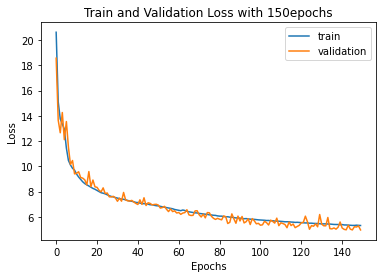

In [19]:
patience=25
# plot training and validation history in the last fold
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience)+' in the last fold.')

In [10]:
#quantitative reuslt: mean square error on test set
mse  

4.328751087188721

In [11]:
predict3=np.zeros((l2r,8))

for i in range(ratio-l2r,ratio):
    predict3[i-ratio+l2r]=predictions[i]
    
predict2=np.zeros((l2r,8))

for i in range(ratio-l2r*2,ratio-l2r):
    predict2[i-ratio+l2r*2]=predictions[i]
    
predict1=np.zeros((l2r,8))

for i in range(ratio-l2r*3,ratio-l2r*2):
    predict1[i-ratio+l2r*3]=predictions[i]

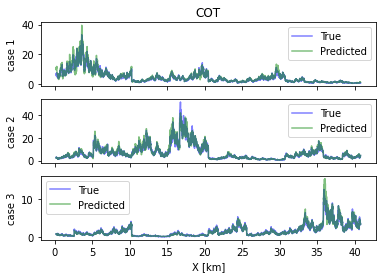

In [21]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+'epochs_3_layers_patience50'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo],data[num-3,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict1.reshape(os*l2r),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo],data[num-2,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict2.reshape(os*l2r),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo],data[num-1,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict3.reshape(os*l2r),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')




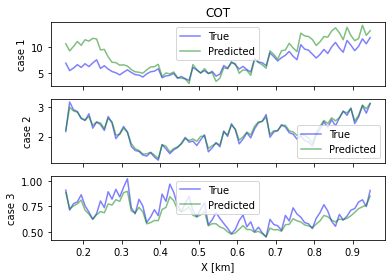

In [22]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"epochs_first_80_pixels"+'_3_layers_patience50'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo][:80],data[num-3,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict1.reshape(4066)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo][:80],data[num-2,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict2.reshape(4066)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo][:80],data[num-1,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo][:80],predict3.reshape(4066)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')